In [1]:
import pandas as pd
import numpy as np
import pymysql
import getpass
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#could use a module for this 
conn = pymysql.connect(host="localhost",
                       port=3306,
                       user="root",
                       passwd=getpass.getpass(),
                       db="olist")

········


# Sellers - After or equal to 2017-01-01
Definition: *A user that has sold a product in a given timeframe*

In [3]:
seller_query = """
SELECT DISTINCT
    oi.seller_id
FROM order_items oi
    INNER JOIN orders o
    ON oi.order_id = o.order_id
WHERE o.order_purchase_timestamp >= '2017-01-01'
"""

In [4]:
sellers = pd.read_sql(seller_query, conn)

In [5]:
sellers.head()

,seller_id
0,3504c0cb71d7fa48d967e0e4c94d59d9
1,289cdb325fb7e7f891c38608bf9e0962
2,4869f7a5dfa277a7dca6462dcf3b52b2
3,66922902710d126a0e7d26b0e3805106
4,2c9e548be18521d1c43cde1c582c6de8


In [6]:
sellers.shape

(3068, 1)

We have had a total of 3068 unique sellers after Jan 1st 2017. 

# 2. How much do they sell?

In [7]:
seller_qt = """
SELECT 
    oi.seller_id,
    COUNT(*)     AS items_sold
FROM order_items oi
    INNER JOIN orders o
    ON oi.order_id = o.order_id
WHERE o.order_purchase_timestamp >= '2017-01-01'
GROUP BY oi.seller_id
"""

In [8]:
seller_qty = pd.read_sql(seller_qt, conn)

In [9]:
seller_qty.shape

(3068, 2)

In [10]:
seller_qty.head()

,seller_id,items_sold
0,3504c0cb71d7fa48d967e0e4c94d59d9,53
1,289cdb325fb7e7f891c38608bf9e0962,126
2,4869f7a5dfa277a7dca6462dcf3b52b2,1156
3,66922902710d126a0e7d26b0e3805106,156
4,2c9e548be18521d1c43cde1c582c6de8,174


In [11]:
seller_qty.describe()

,items_sold
count,3068.000000
mean,36.597132
std,119.512140
min,1.000000
25%,2.000000
50%,8.000000
75%,25.000000
max,2033.000000


- Lots of outliers
- Top seller has sold 2033
- A lot of sellers who don't sell much
- The mean is much higher than the 50% percentile
- 25% of our sellers have sold 2 or fewer items
- 50% of our sellers have sold 8 or fewer items
- A quarter of our sellers have sold over 25 items
- The lowest performing seller has sold 1 item

In [12]:
type(seller_qty.describe())

pandas.core.frame.DataFrame

In [18]:
seller_qty.describe().loc["mean"]

items_sold    36.597132
Name: mean, dtype: float64

In [19]:
#other way to do it
seller_qty.describe().iloc[1]

items_sold    36.597132
Name: mean, dtype: float64

In [20]:
seller_qty["items_sold"].mean()

36.59713168187744

In [21]:
np.percentile(seller_qty["items_sold"], 50)

8.0

In [22]:
np.quantile(seller_qty["items_sold"], 0.5)

8.0

Draw a box and whisker plot, using built-in pandas method

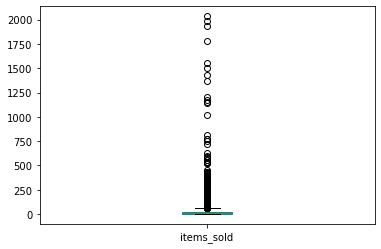

In [23]:
seller_qty["items_sold"].plot(kind="box");

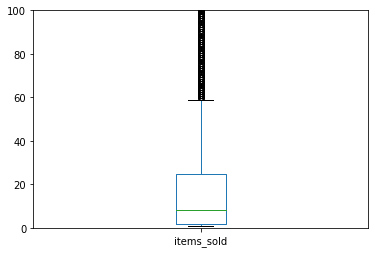

In [25]:
seller_qty["items_sold"].plot(kind="box", ylim=(0,100));

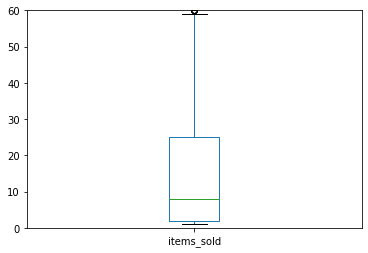

In [26]:
seller_qty["items_sold"].plot(kind="box", ylim=(0,60));

In [27]:
seller_qty.loc[seller_qty["items_sold"]>58].shape

(409, 2)

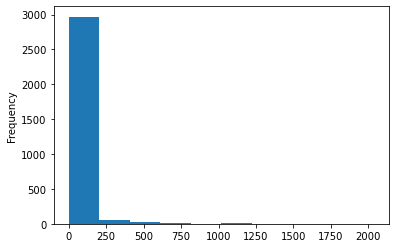

In [28]:
seller_qty["items_sold"].plot(kind="hist");

Interpretation -Anythin over 750 is so rare that you almost cannot see it in comparison to how many fall into the first bin.

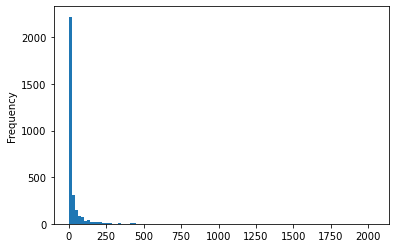

In [29]:
seller_qty["items_sold"].plot(kind="hist", bins=100);

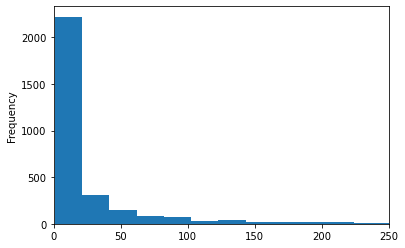

In [33]:
seller_qty["items_sold"].plot(kind="hist", bins=100, xlim=(0,250));

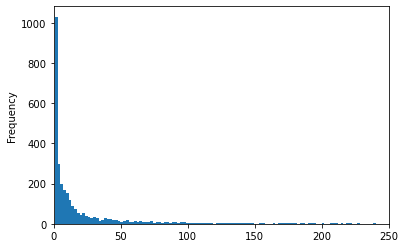

In [34]:
seller_qty["items_sold"].plot(kind="hist", bins=1000, xlim=(0,250));

In [35]:
np.percentile(seller_qty["items_sold"], 1)

1.0

In [36]:
np.percentile(seller_qty["items_sold"], 25)

2.0

In [37]:
np.percentile(seller_qty["items_sold"], [1,2,3])

array([1., 1., 1.])

In [38]:
seller_qty["items_sold"].quantile(.25)

2.0

In [40]:
seller_qty["items_sold"].quantile([x/100 for x in range(1,100)])

0.01      1.00
0.02      1.00
0.03      1.00
0.04      1.00
0.05      1.00
         ...  
0.95    147.65
0.96    177.32
0.97    211.99
0.98    304.64
0.99    432.32
Name: items_sold, Length: 99, dtype: float64

In [42]:
seller_qty["items_sold"].quantile([x/10 for x in range(1,10)])

0.1     1.0
0.2     2.0
0.3     3.0
0.4     5.0
0.5     8.0
0.6    11.0
0.7    18.0
0.8    35.0
0.9    81.0
Name: items_sold, dtype: float64

# 3. How much revenue are they generating?

In [43]:
seller_rev_query = """
SELECT 
    oi.seller_id,
    COUNT(*)        AS items_sold, 
    SUM(oi.price)   AS revenue
FROM order_items oi
    INNER JOIN orders o
    ON oi.order_id = o.order_id
WHERE o.order_purchase_timestamp >= '2017-01-01'
GROUP BY oi.seller_id
"""

In [44]:
sellers_rev = pd.read_sql(seller_rev_query, conn)

In [45]:
sellers_rev.head()

,seller_id,items_sold,revenue
0,3504c0cb71d7fa48d967e0e4c94d59d9,53,2349.940056
1,289cdb325fb7e7f891c38608bf9e0962,126,13544.950102
2,4869f7a5dfa277a7dca6462dcf3b52b2,1156,229472.628349
3,66922902710d126a0e7d26b0e3805106,156,14362.300011
4,2c9e548be18521d1c43cde1c582c6de8,174,6109.440094


In [47]:
sellers_rev["revenue"].describe()

count      3068.000000
mean       4413.904101
std       13945.167724
min           3.500000
25%         210.150003
50%         829.920002
75%        3322.785002
max      229472.628349
Name: revenue, dtype: float64

In [48]:
sellers_rev.describe()

,items_sold,revenue
count,3068.000000,3068.000000
mean,36.597132,4413.904101
std,119.512140,13945.167724
min,1.000000,3.500000
25%,2.000000,210.150003
50%,8.000000,829.920002
75%,25.000000,3322.785002
max,2033.000000,229472.628349


- The mean is higher than our median, similar to items_sold. This means that our data is right skewed. Most of our sellers are making relatively little money, while a few sellers are making the most. 
- Only 25% of our sellers are making more than 3322

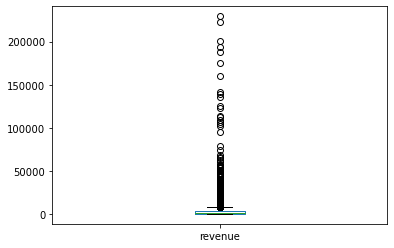

In [49]:
sellers_rev["revenue"].plot(kind="box");

Because only 25% percent of people are bringing in most of the revenue or over 3322, these are the people we need to focus our efforts on and make sure they don't leave.    

# How much do we depend on the top sellers?

In [50]:
top_seller = sellers_rev.copy()

In [53]:
#sorting the data based on revenue and resetting the index
top_seller = (top_seller
              .sort_values("revenue", ascending=False)
              .reset_index(drop=True))

In [54]:
top_seller.head()

,seller_id,items_sold,revenue
0,4869f7a5dfa277a7dca6462dcf3b52b2,1156,229472.628349
1,53243585a1d6dc2643021fd1853d8905,410,222776.049545
2,4a3ca9315b744ce9f8e9374361493884,1987,200472.921459
3,fa1c13f2614d7b5c4749cbc52fecda94,586,194042.029396
4,7c67e1448b00f6e969d365cea6b010ab,1364,187923.891939


In [60]:
#getting the rank from the index
top_seller = (top_seller
             .assign(rank=top_seller.index+1)
# getting the cumulative sum over revnue
             .assign(cum_rev=top_seller["revenue"].cumsum()))

In [61]:
top_seller.head()

,seller_id,items_sold,revenue,rank,cum_rev
0,4869f7a5dfa277a7dca6462dcf3b52b2,1156,229472.628349,1,2.294726e+05
1,53243585a1d6dc2643021fd1853d8905,410,222776.049545,2,4.522487e+05
2,4a3ca9315b744ce9f8e9374361493884,1987,200472.921459,3,6.527216e+05
3,fa1c13f2614d7b5c4749cbc52fecda94,586,194042.029396,4,8.467636e+05
4,7c67e1448b00f6e969d365cea6b010ab,1364,187923.891939,5,1.034688e+06


In [65]:
top_seller = top_seller.assign(relative_rank=(top_seller["rank"]/len(top_seller)))

In [66]:
top_seller.head()

,seller_id,items_sold,revenue,rank,cum_rev,relative_rank
0,4869f7a5dfa277a7dca6462dcf3b52b2,1156,229472.628349,1,2.294726e+05,0.000326
1,53243585a1d6dc2643021fd1853d8905,410,222776.049545,2,4.522487e+05,0.000652
2,4a3ca9315b744ce9f8e9374361493884,1987,200472.921459,3,6.527216e+05,0.000978
3,fa1c13f2614d7b5c4749cbc52fecda94,586,194042.029396,4,8.467636e+05,0.001304
4,7c67e1448b00f6e969d365cea6b010ab,1364,187923.891939,5,1.034688e+06,0.001630


In [69]:
# multiplying by 100 so easy to interperate as %
top_seller = top_seller.assign(revenue_contribution=
                  (top_seller["cum_rev"]/top_seller["revenue"].sum()*100))

In [71]:
top_seller.head(20)

,seller_id,items_sold,revenue,rank,cum_rev,relative_rank,revenue_contribution
0,4869f7a5dfa277a7dca6462dcf3b52b2,1156,229472.628349,1,2.294726e+05,0.000326,1.694543
1,53243585a1d6dc2643021fd1853d8905,410,222776.049545,2,4.522487e+05,0.000652,3.339635
2,4a3ca9315b744ce9f8e9374361493884,1987,200472.921459,3,6.527216e+05,0.000978,4.820030
3,fa1c13f2614d7b5c4749cbc52fecda94,586,194042.029396,4,8.467636e+05,0.001304,6.252935
4,7c67e1448b00f6e969d365cea6b010ab,1364,187923.891939,5,1.034688e+06,0.001630,7.640662
5,7e93a43ef30c4f03f38b393420bc753a,339,175032.869331,6,1.209720e+06,0.001956,8.933194
6,da8622b14eb17ae2831f4ac5b9dab84a,1551,160236.568089,7,1.369957e+06,0.002282,10.116462
7,7a67c85e85bb2ce8582c35f2203ad736,1171,141745.531660,8,1.511702e+06,0.002608,11.163184
8,1025f0e2d44d7041d6cf58b6550e0bfa,1428,138968.550537,9,1.650671e+06,0.002934,12.189399
9,955fee9216a65b617aa5c0531780ce60,1499,135171.700697,10,1.785843e+06,0.003259,13.187576


In [72]:
top_seller.loc[top_seller["revenue_contribution"].between(49,51)]

,seller_id,items_sold,revenue,rank,cum_rev,relative_rank,revenue_contribution
122,59fb871bf6f4522a87ba567b42dafecf,127,21598.580399,123,6.643533e+06,0.040091,49.059241
123,d2374cbcbb3ca4ab1086534108cc3ab7,631,21223.920174,124,6.664757e+06,0.040417,49.215969
124,48162d548f5b1b11b9d29d1e01f75a61,91,20510.139845,125,6.685267e+06,0.040743,49.367427
125,729f06993dac8e860d4f02d7088ca48a,115,20485.079700,126,6.705752e+06,0.041069,49.518699
126,00ee68308b45bc5e2660cd833c3f81cc,172,20260.000000,127,6.726012e+06,0.041395,49.668309
127,bfd27a966d91cfaafdb25d076585f0da,118,19921.000000,128,6.745933e+06,0.041721,49.815416
128,004c9cd9d87a3c30c522c48c4fc07416,170,19712.710007,129,6.765646e+06,0.042047,49.960985
129,d650b663c3b5f6fb392b6326366efa9a,60,19242.899994,130,6.784888e+06,0.042373,50.103084
130,821fb029fc6e495ca4f08a35d51e53a5,29,19187.419968,131,6.804076e+06,0.042699,50.244774
131,f457c46070d02cadd8a68551231220dd,234,19093.000183,132,6.823169e+06,0.043025,50.385766
